# Implementing an individual-based model (IBM)

In this chapter, we will implement a model from the general class of *agent-based models*. The term agent is used throughout science to indicate an autonomous unit that can make decisions to achieving a particular goal, and that adapts these decisions to changes in the environment or situation that it experiences. In ecology, an agent is often an individual organism. Each individual organism is described by a set of characteristics, for instance it’s coordinates in space, it’s size, or whether it is hungry or not (e.g., a state). 

The approach to have a finite set of discrete organisms that have a specific location in space, rather then sitting somewhere in a grid, is profoundly different from the approach where we have a certain amount of a substance or of organims, spreading over a grid. The first approach models movement of different individuals as a change in x, y and z coordinates, while the latter describes a flux over the boundaries of a spatially bounded area.

In programming, a separate approach has been developed that aims to facilitate the programming of "agents", being individual organisms, actors, or even an individual button on your computer screen. This approach is called Object-Oriented Programming (or OOP). In this lecture, I will provide you with some basic explanation of how to use an OOP approach in python, and give an example model dealing with pattern formation in individual mussels (of course).

# Object-oriented programming in python: Classes
The basic premise of object-oriented programming is to package both the variables and the computing procedures that define a certain object in a single self-contained data structure. The wikipedia definition reads:   

*"Object-oriented programming (OOP) is a programming paradigm based on the concept of "objects", which may contain data, in the form of fields, often known as attributes; and code, in the form of procedures, often known as methods."*

The methods should in principle access and modify the variables that are contained in the object, and can provide a generalized interface with which to handle or extract information from the object. 

In Python, an object can be define by means of a `Class`. A Class definition contains both data and procedures, as in the following example of individual that is characterized by an age:

In [1]:
class A_Kid:
    i = 0
    def HowOld(self):
        print('I am %d years old.' % self.i)   
    
Ikkie = A_Kid()    
Ikkie.HowOld()

### Aging
We will now add a method called `Aging` that will have the object age by one year. We will then create a loop that run `Aging` for three times, and ask how old the object is.

In [2]:
class A_Kid:
    i = 0
    def HowOld(self):
        print('I am %d years old.' % self.i)       
    def Grow(self):
        self.i = self.i+1

In [3]:
Ikkie = A_Kid()

for jaar in range(3):
    Ikkie.Grow()

In [4]:
Ikkie.HowOld()

I am 3 years old.


## Self-organized mussel patterns

We develop a python code of the model in the following paper:

The citation is:  
*Van de Koppel, J., Gascoigne, J.C., Theraulaz, G., Rietkerk, M., Mooij W.M., & Herman, P.M.J. 2008 Experimental evidence for spatial self-organization and its emergent effects in mussel beds. Science 322:739-742.*

When the relation between the movement speed and the number of neighbors was investigated, a complex behavior was observed. The behavior can be summarized as follows:  
•	Mussels move with high speed when they are alone.  
•	When the number of mussels in the direct neighborhoods increases, mussel movement speed decreases.  
•	When the number of mussels in the total aggregate, at a scale of +- 10 cm, increases too much, mussels again start to move faster, moving out of clusters that are too large.  

# Self-organized mussel patterns

<iframe width="1120" height="630" src="https://www.youtube.com/embed/pwZZiNHyTgI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



### Self-organized mussel patterns, continued ...

In this section, we will model the movement of mussels to test whether the above description of individual movement is sufficient to recreate the patterns that are described in the paper. For this, we will describe mussel movement, in terms of its step size and direction per time unit, as a stochastic process, e.g., a random walk. The step size is not entirely random, of course, but is a function of the local density of mussels. Inspection of the data revealed that the mussels do random walk that is best described by an exponential distribution of step sizes:  
$$
\begin{aligned}
F(x)= \frac{1}{β} exp \big(\frac{-x}{β}\big), 
\end{aligned}
$$

Here, x is the step size and β a scaling parameter).

We need to develop a program in which for instance the changes in the organism’s physical location, its’ growth and its decisions are explicitly modeled. Below, we will develop a simple individual-based model in Python, using self-organized patch formation of mussels as an example.

Below, we implement this model in Python

### Loading required modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time, os
%matplotlib inline

### Parameter definition 

In [6]:
Nr           =  2000;    # Total number of mussels
Length       =  50.0;    # Length of the arena 
EndTime      =   300;    # 300 - Number of timesteps in minutes

# Parameters of the function relating density to movement speed
P1           = 100.0;    # 100
P2           = -80.0;    # -80
P3           =   3.0;    # 3

D1           =   2.0;    # 2 - Size of the direct neighborhood
D2           =   6.0;    # 6 - Size of the cluster neighborhood

### Graphical parameters

In [7]:
WinWidth     =   960;    #   - Width of the simulation window 
WinHeight    =   720;    #   - Height of the simulation window

MusselSize   = (1500.0/Length)  # Size of the marker

### Array declarations

In [8]:
Stepsize  = np.zeros(Nr)
Angle     = np.zeros(Nr)
Distance  = np.zeros((Nr,Nr))
Diagonal  = np.zeros((Nr,Nr))
np.fill_diagonal(Diagonal, 1)

## Randomly distributing the data across the domain
X=np.random.rand(Nr)*Length
Y=np.random.rand(Nr)*Length

### 2 functions to compute the distance matrix

In [9]:
def dist(x,y):
    dx = x[..., np.newaxis] - x[np.newaxis, ...]
    dy = y[..., np.newaxis] - y[np.newaxis, ...]
    d = np.array([dx,dy])
    return (d**2).sum(axis=0)**0.5

In [10]:
from numba import njit,prange

@njit(parallel=True)
def distp(x,y):
    d = np.zeros((x.shape[0],y.shape[0]))
    for j in prange(y.shape[0]):
        for i in prange(x.shape[0]): 
            d[i,j]=np.sqrt( (x[j]-x[i])**2 + (y[j]-y[i])**2)
    return d

### A function that runs the model for one time step

In [11]:
def RunModel(X,Y): 
    # Calculating distances between all individual mussels
    Distance=dist(X,Y)
  
    # Checking which mussels are within ranges D1 and D2
    Nr_In_Dist1 = (Distance<D1)*1.0-Diagonal
    Nr_In_Dist2 = (Distance<D2)*1.0-Diagonal
  
    # Calculating, for each mussel, the density of the local neighborhood
    Density_In_Dist1 = Nr_In_Dist1.sum(axis=0)/(D1**2*np.pi) # sum/surface
    Density_In_Dist2 = Nr_In_Dist2.sum(axis=0)/(D2**2*np.pi) # sum/surface
  
    # Determining StepSize and Angle from the Densities
    Beta = 1/(np.maximum(0.001,P1*Density_In_Dist1+P2*Density_In_Dist2)+P3)
    Stepsize = - Beta * np.log(np.random.rand(Nr))
    Angle = np.random.rand(Nr)*360.0
  
    # Converting Speed S en Angle A to new X and Y coordinates
    X = ( X + np.sin(Angle/180.0*np.pi)*Stepsize ) % Length
    Y = ( Y + np.cos(Angle/180.0*np.pi)*Stepsize ) % Length
      
    return X,Y

### Main simulation loop

In [12]:
# Storage variables
Xs=np.zeros((Nr,EndTime))
Ys=np.zeros((Nr,EndTime))

# Setting up time profiling
start_time = time.time()

for Time in range(EndTime):
    
    # Running a single model iteration
    X,Y = RunModel(X,Y)
    
    # Storing the data
    Xs[:,Time]=X
    Ys[:,Time]=Y

elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 31.9 (s)


### Plotting the results

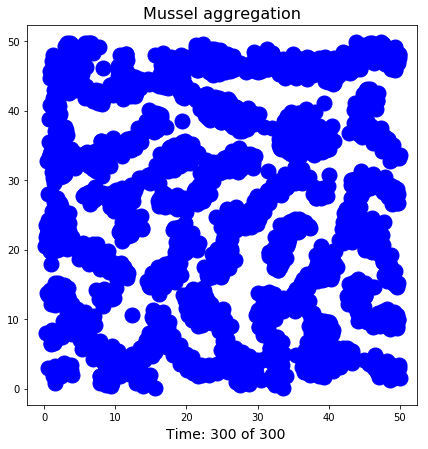

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
P, = ax.plot(X,Y, 'b.', markersize=MusselSize);
ax.set_title("Mussel aggregation", fontsize=16)
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime, EndTime)), x=0.52, y=0.08, fontsize=14);

### Making an animation

In [14]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    P.set_xdata(Xs[:,i])
    P.set_ydata(Ys[:,i])
    text.set_text("Time: %01.0f of %1.0f" % (i+1, EndTime));
    return P,

ani = animation.FuncAnimation(fig, updatefig, 
                              interval=100, frames = EndTime, repeat=False, blit=True)

from IPython.display import HTML

In [15]:
HTML(ani.to_html5_video())

### A Class-based setup
Here we implementing a basic object-oriented programming approach

In [16]:
class MusselKernel:

    def __init__(self, N=100):
        self.N=N

        ## Randomly distributing the data across the domain
        self.X=np.random.rand(N)*Length
        self.Y=np.random.rand(N)*Length
        
        self.Diagonal  = np.zeros((N,N))
        np.fill_diagonal(self.Diagonal, 1)
        
    def run(self):
        # Calculating distances between all individual mussels
        Distance=dist(self.X,self.Y)

        # Checking which mussels are within ranges D1 and D2
        Nr_In_Dist1 = (Distance<D1)*1.0-self.Diagonal
        Nr_In_Dist2 = (Distance<D2)*1.0-self.Diagonal

        # Calculating, for each mussel, the density of the local neighborhood
        Density_In_Dist1 = Nr_In_Dist1.sum(axis=0)/(D1**2*np.pi) # sum/surface
        Density_In_Dist2 = Nr_In_Dist2.sum(axis=0)/(D2**2*np.pi) # sum/surface

        # Determining StepSize and Angle from the Densities
        Beta = 1/(np.maximum(0.001,P1*Density_In_Dist1+P2*Density_In_Dist2)+P3)
        Stepsize = - Beta * np.log(np.random.rand(self.N))
        Angle = np.random.rand(self.N)*360.0

        # Converting Speed S en Angle A to new X and Y coordinates
        self.X = ( self.X + np.sin(Angle/180.0*np.pi)*Stepsize ) % Length
        self.Y = ( self.Y + np.cos(Angle/180.0*np.pi)*Stepsize ) % Length    

### The main simulation loop

In [17]:
# Storage variables
Xs=np.zeros((Nr,EndTime))
Ys=np.zeros((Nr,EndTime))

Mussels=MusselKernel(Nr)

# Setting up time profiling
start_time = time.time()

for Time in range(EndTime):
    
    Mussels.run()

    Xs[:,Time]=Mussels.X
    Ys[:,Time]=Mussels.Y

elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 32.3 (s)


### Plotting the results

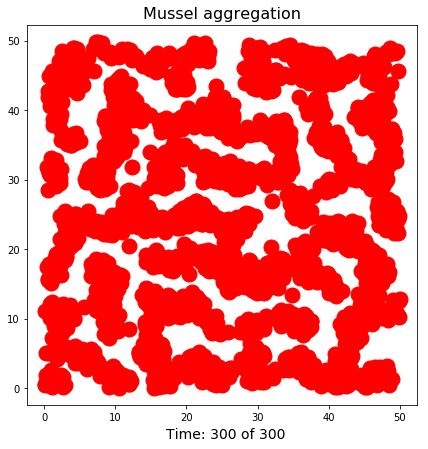

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
P, = ax.plot(Mussels.X,Mussels.Y, 'r.', markersize=MusselSize);
ax.set_title("Mussel aggregation", fontsize=16)
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime, EndTime)), x=0.52, y=0.08, fontsize=14);

### Defining the objects

In [19]:
Nr = 200
Length = 25.0

class Mussel:

    def __init__(self):

        ## Randomly distributing the data across the domain
        self.X=np.random.rand(1)*Length
        self.Y=np.random.rand(1)*Length
        
    def Move(self,OtherMussels):
        
        Nr_In_Dist1=0; Nr_In_Dist2=0;

        # For every mussel in the system, check if its within distance D1 or D2
        for other in OtherMussels:
            
            d = np.sqrt( (self.X - other.X)**2 + (self.Y - other.Y)**2 )
 
            if 0 < d < D1:
                Nr_In_Dist1 += 1       # Keep track of how many
            if 0 < d < D2:
                Nr_In_Dist2 += 1       # Keep track of how many    
        
        # Calculating, for each mussel, the density of the local neighborhood
        Density_In_Dist1 = Nr_In_Dist1/(D1**2*np.pi); # sum/surface
        Density_In_Dist2 = Nr_In_Dist2/(D2**2*np.pi); # sum/surface

        # Determining StepSize and Angle from the Densities
        Beta = 1/(max(0.001,P1*Density_In_Dist1+P2*Density_In_Dist2)+P3);
        Stepsize = - Beta * np.log(np.random.rand(1));
        Angle = np.random.rand(1)*360.0;

        # Converting Speed S en Angle A to new X and Y coordinates
        self.X = self.X + np.sin(Angle/180.0*np.pi)*Stepsize;
        self.Y = self.Y + np.cos(Angle/180.0*np.pi)*Stepsize;
        
    def StayIn(self):
        self.X=self.X % Length
        self.Y=self.Y % Length 

### Also defining a class for the entire mussel bed, containing a number of mussels

In [20]:
class MusselBed:
    def __init__(self, N=100):
        self.AllMussels = []
        for i in range(N):
            mussel = Mussel()
            self.AllMussels.append(mussel)

    def run(self):
        for mussel in self.AllMussels:
            # Passing the entire list of boids to each boid individually
            mussel.Move(self.AllMussels)
            mussel.StayIn()  

### Main simulation loop

In [21]:
# Storage variables
Xs=np.zeros((Nr,EndTime))
Ys=np.zeros((Nr,EndTime))

Mussels=MusselBed(Nr)

# Setting up time profiling
start_time = time.time()

for Time in range(EndTime):
    
    Mussels.run()
    
    for i,mussel in enumerate(Mussels.AllMussels):

        Xs[i,Time]=mussel.X
        Ys[i,Time]=mussel.Y

elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

 Simulation took      : 109.3 (s)


### Plotting the results

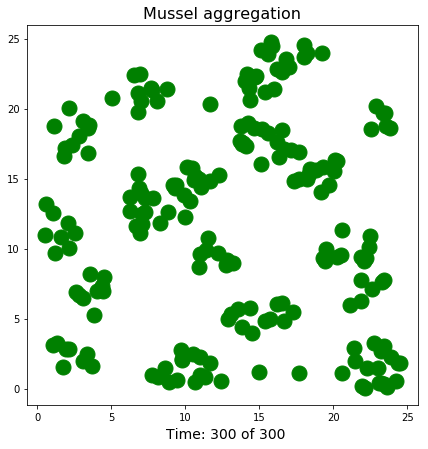

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
P, = ax.plot(Xs[:,EndTime-1],Ys[:,EndTime-1], 'g.', markersize=MusselSize);
ax.set_title("Mussel aggregation", fontsize=16)
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime, EndTime)), x=0.52, y=0.08, fontsize=14);

© Johan van de Koppel, NIOZ-Yerseke 2018